In [1]:
!pip install transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

**Descriptive Analysis (Statistics & Trends)**

In [7]:
# Loading the dataset
df = pd.read_csv('DisasterTweets.csv')

# Converting 'Timestamp' to datetime objects so we can analyze time
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extracting the Date (without the time) for daily grouping
df['Date'] = df['Timestamp'].dt.date

**Analyzing Disaster Frequency**

/tmp/ipython-input-2774012841.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disaster_counts.index, y=disaster_counts.values, palette='viridis')


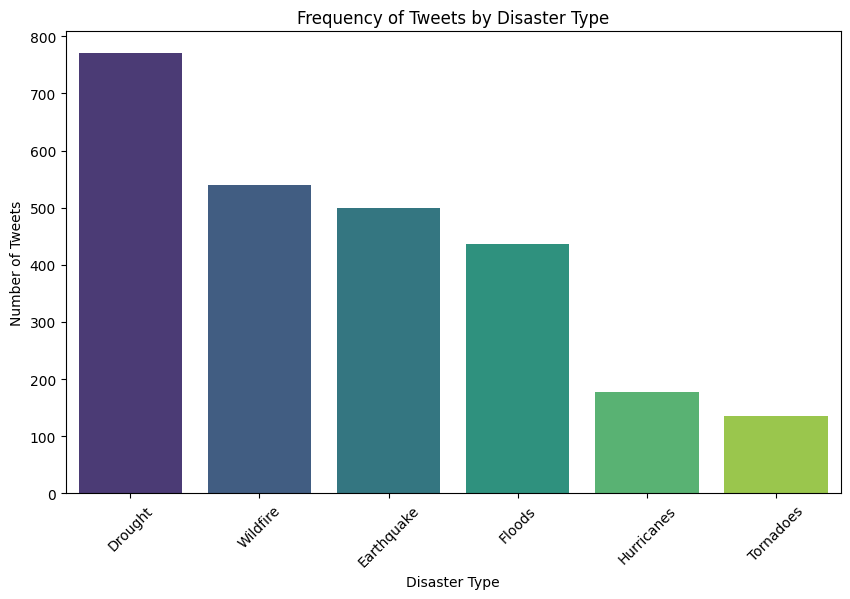

In [8]:
# Counting how many tweets there are for each disaster type
disaster_counts = df['Disaster'].value_counts()

# Plotting the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=disaster_counts.index, y=disaster_counts.values, palette='viridis')
plt.title('Frequency of Tweets by Disaster Type')
plt.xlabel('Disaster Type')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

**Analyzing Engagement (Likes)**

Disaster
Tornadoes     14.385185
Floods        12.753456
Wildfire      12.085185
Drought        6.530559
Hurricanes     6.404494
Earthquake     2.438000
Name: Likes, dtype: float64


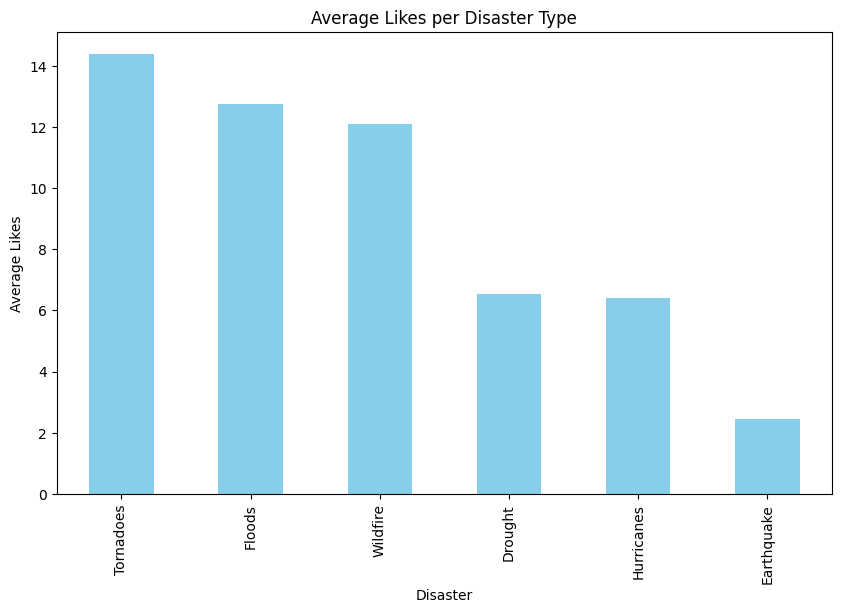

In [11]:
# Converting the 'Likes' column to numbers.
df['Likes'] = pd.to_numeric(df['Likes'], errors='coerce')

avg_likes = df.groupby('Disaster')['Likes'].mean().sort_values(ascending=False)
print(avg_likes)

# Plotting
plt.figure(figsize=(10, 6))
avg_likes.plot(kind='bar', color='skyblue')
plt.title('Average Likes per Disaster Type')
plt.ylabel('Average Likes')
plt.show()

**Text Analysis (NLP & Word Clouds)**

In [12]:
import re
from wordcloud import WordCloud, STOPWORDS

def clean_text(text):
    # Converting to lowercase
    text = str(text).lower()
    # Removing URLs (http/https)
    text = re.sub(r'http\S+', '', text)
    # Removing punctuation and special characters (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Applying the cleaning function to the Tweets column
df['Clean_Tweets'] = df['Tweets'].apply(clean_text)

**Generating a Word Cloud**

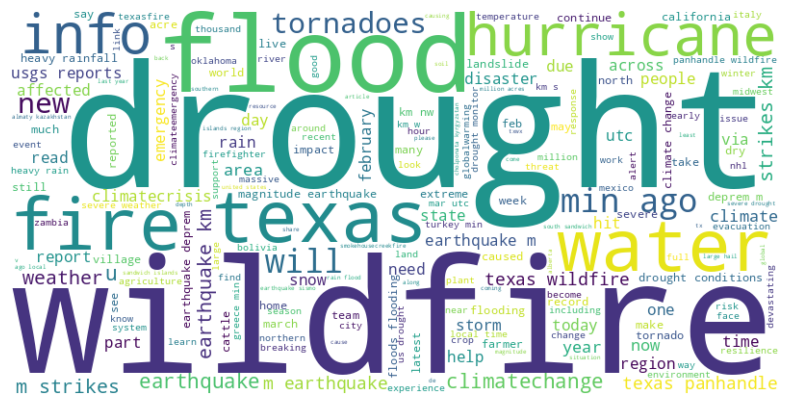

In [13]:
# Combining all cleaned tweets into one big string
all_text = " ".join(tweet for tweet in df.Clean_Tweets)

stopwords = set(STOPWORDS)
stopwords.update(["https", "t", "co", "amp"])

# Generating the Word Cloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

** Machine Learning (Classification)**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

mask = ~df['Tweets'].str.contains('NHL|Sabres|Hurricanes|canesfootball|collegefootball', case=False, na=False)
df_clean = df[mask]

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

X = vectorizer.fit_transform(df_clean['Clean_Tweets'])
y = df_clean['Disaster']

**Splitting and Training**

In [15]:
# Spliting data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()

model.fit(X_train, y_train)

MultinomialNB()

**Evaluation**

In [17]:
# Find the unique labels that are actually present in the test set
labels_in_test = y_test.unique()

print("Classification Report:")
print(classification_report(y_test, predictions, target_names=labels_in_test))

Classification Report:
              precision    recall  f1-score   support

     Drought       0.87      0.94      0.90       160
      Floods       1.00      0.98      0.99        96
  Earthquake       0.90      0.80      0.85        82
   Tornadoes       1.00      0.87      0.93        30
    Wildfire       0.90      0.92      0.91       106

    accuracy                           0.91       474
   macro avg       0.93      0.90      0.92       474
weighted avg       0.92      0.91      0.91       474



**Testing with a Custom Tweet**

In [18]:
new_tweet = ["Heavy rain is causing the river to overflow and homes are flooding."]

new_tweet_cleaned = [clean_text(t) for t in new_tweet]
new_tweet_vectorized = vectorizer.transform(new_tweet_cleaned)

# Prediction
prediction = model.predict(new_tweet_vectorized)
print(f"The model predicts this tweet is about: {prediction[0]}")

The model predicts this tweet is about: Floods


In [19]:
import joblib

joblib.dump(model, 'disaster_classifier_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Model and Vectorizer saved successfully!")

Model and Vectorizer saved successfully!


In [21]:
loaded_model = joblib.load('disaster_classifier_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')